In [1]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [2]:
# define constants
RETURNS_LOOKBACK = 30
FUNDING_LOOKBACK = 10
TARGET_VOLATILITY = 1/math.sqrt(365)
print(TARGET_VOLATILITY)

0.052342392259021375


In [3]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

# asset funding volatility
df["rolling_funding_vol"] = (
    df.groupby("asset")["funding"]
      .rolling(window=FUNDING_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# asset returns and funding volatility
df["rolling_returns_funding_vol"] = (
    df.groupby("asset")["returns_funding"]
      .rolling(window=RETURNS_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# check work
df.iloc[50:56].head()

,timestamp,asset,open,high,low,close,volume,funding,funding inaccurate,returns,returns_funding,next_returns_funding,rolling_funding_vol,rolling_returns_funding_vol
50,2025-01-25 20:00:00,1000BONK-USD,0.029637,0.029813,0.028716,0.029260,574900.0,-0.000037,24,-0.012721,-0.012684,-0.154063,0.001109,0.075372
51,2025-01-26 20:00:00,1000BONK-USD,0.029260,0.029260,0.024299,0.024748,1239300.0,-0.000141,24,-0.154204,-0.154063,0.008947,0.001093,0.080323
52,2025-01-27 20:00:00,1000BONK-USD,0.024748,0.026785,0.024748,0.024954,982400.0,-0.000623,24,0.008324,0.008947,-0.001621,0.001098,0.079880
53,2025-01-28 20:00:00,1000BONK-USD,0.024954,0.025741,0.022771,0.024913,1317900.0,-0.000022,24,-0.001643,-0.001621,0.014194,0.000887,0.079750
54,2025-01-29 20:00:00,1000BONK-USD,0.024913,0.026438,0.023934,0.025254,1091300.0,-0.000506,24,0.013688,0.014194,-0.012058,0.000569,0.079690


In [4]:
# creating funding signals

for i in [3, 5, 10, 15, 25, 40, 55]:
    
    df[f"funding_sma{i}"] = (
    df.groupby("asset")["funding"]
      .rolling(window=i)
      .mean()
      .reset_index(level=0, drop=True)
    )

    df[f"funding_sig{i}"] = df["funding"]/df[f"funding_sma{i}"]

In [5]:
# scaling returns and funding by volatility
df["returns_funding_volscaled"] = df["returns_funding"]*(TARGET_VOLATILITY/df["rolling_returns_funding_vol"])

# next day asset returns and funding scaled by volatility
df["next_returns_funding_volscaled"] = (
    df.groupby("asset")["returns_funding_volscaled"]
      .shift(-1)
)

# editing to remove what wont yet include a volatility scale and final day
df = df[df.groupby('asset').cumcount() > 55].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

               timestamp    asset    open    high     low   close  volume  \
1355 2024-12-06 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1356 2024-12-07 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1357 2024-12-08 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1358 2024-12-09 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1359 2024-12-10 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1360 2024-12-11 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1361 2024-12-12 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1362 2024-12-13 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1363 2024-12-14 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1364 2024-12-15 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   
1365 2024-12-16 20:00:00  ADA-USD  1.2331  1.2331  1.2331  1.2331     0.0   

      funding  funding inaccurate  returns  ...  funding_sma15  funding_sig

In [6]:
idx_max = df["next_returns_funding_volscaled"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding_volscaled"].idxmin()
print(df.loc[idx_min])

timestamp                         2025-02-28 20:00:00
asset                                         ADA-USD
open                                            0.636
high                                           0.6517
low                                            0.6282
close                                          0.6424
volume                                         1560.0
funding                                     -0.000301
funding inaccurate                                 24
returns                                      0.010063
returns_funding                              0.010364
next_returns_funding                         0.620888
rolling_funding_vol                          0.001144
rolling_returns_funding_vol                  0.042673
funding_sma3                                 0.000526
funding_sig3                                -0.572243
funding_sma5                                 0.000498
funding_sig5                                -0.604904
funding_sma10               

In [7]:
# create funding deciles
for i in [3, 5, 10, 15, 25, 40, 55]:
    df[f"funding_decile{i}"] = 0
    df[f"funding_decile{i}_scaled"] = 0

    # per day deciles across all assets
    df[f'funding_decile{i}'] = df.groupby('timestamp')[f'funding_sig{i}'] \
        .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
56    2025-01-31 20:00:00  1000BONK-USD       0.024936       0.025613   
472   2025-01-31 20:00:00  1000PEPE-USD       0.014007       0.014258   
762   2025-01-31 20:00:00  1000SHIB-USD       0.018872       0.019227   
1411  2025-01-31 20:00:00       ADA-USD       0.945700       0.954300   
1852  2025-01-31 20:00:00       ARB-USD       0.649000       0.651800   
2271  2025-01-31 20:00:00      AVAX-USD      34.720000      35.070000   
2909  2025-01-31 20:00:00       BNB-USD     679.200000     681.400000   
3332  2025-01-31 20:00:00       BTC-USD  102375.600000  102753.100000   
3780  2025-01-31 20:00:00      DOGE-USD       0.327960       0.330150   
4475  2025-01-31 20:00:00       ETH-USD    3339.420000    3341.010000   
5021  2025-01-31 20:00:00      GOAT-USD       0.203700       0.207700   
6751  2025-01-31 20:00:00      LINK-USD      24.897000      25.905000   
7157  2025-01-31 20:00:00       LTC-USD     126.150

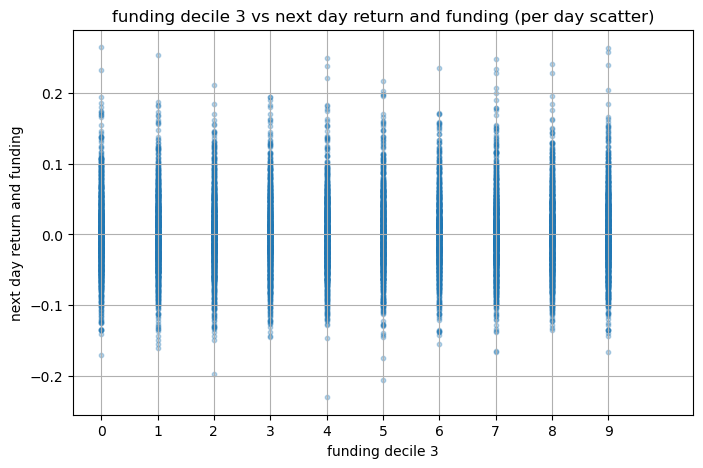

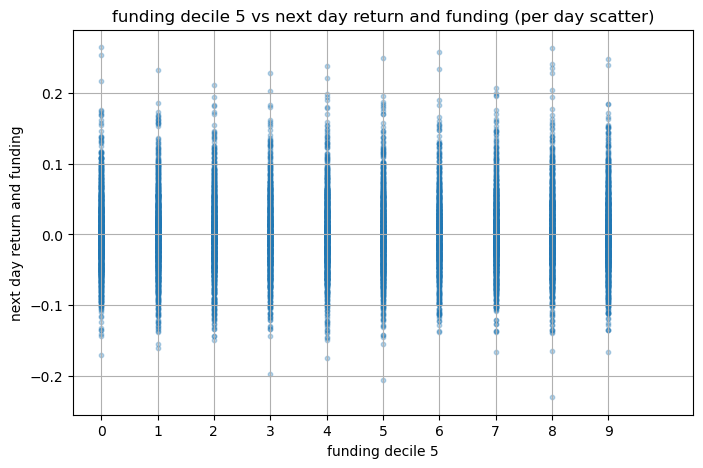

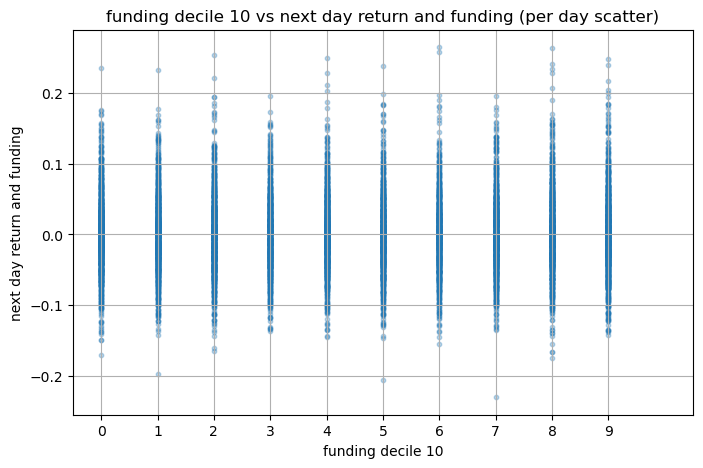

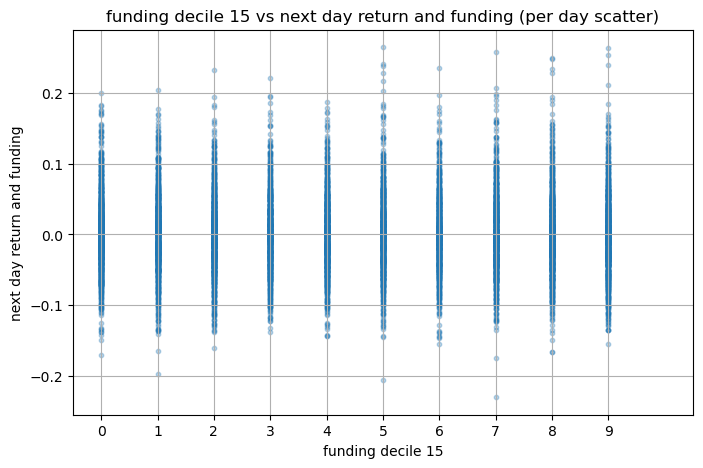

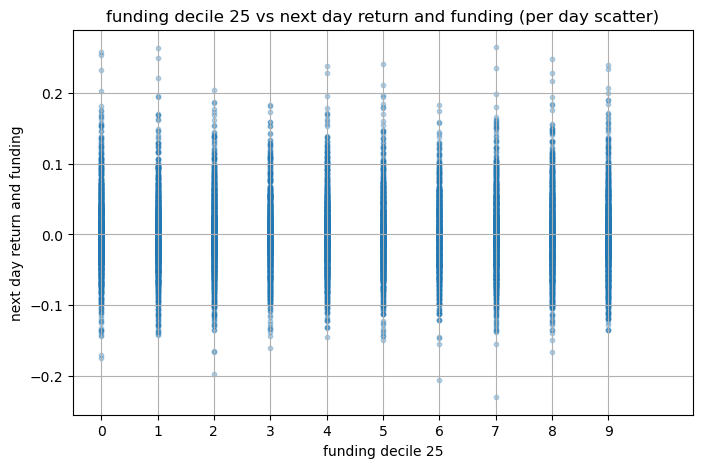

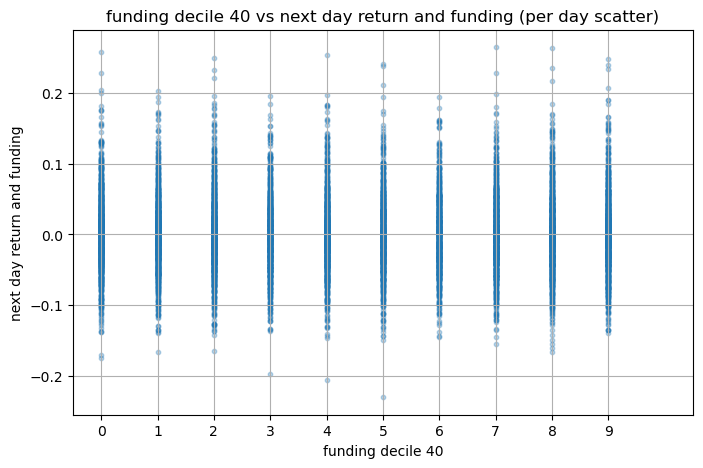

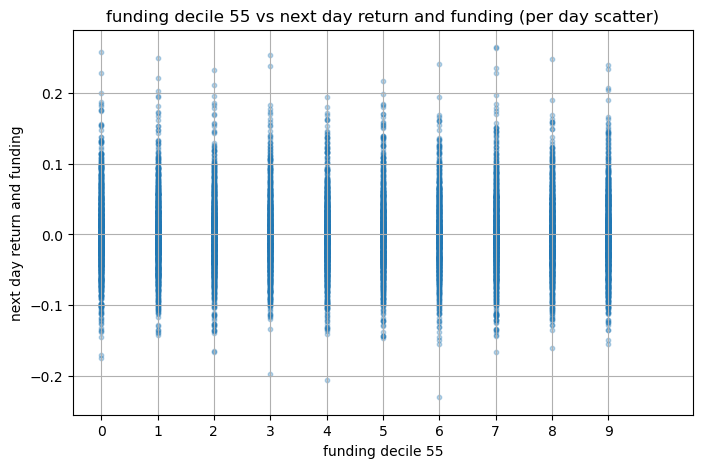

In [8]:
# scatter plot to gain initial intuiton
for i in [3, 5, 10, 15, 25, 40, 55]:

    plt.figure(figsize=(8,5))
    plt.scatter(
        df[f"funding_decile{i}"], 
        df["next_returns_funding_volscaled"], 
        alpha=0.3, 
        s=10
    )

    plt.xlabel(f"funding decile {i}")
    plt.ylabel("next day return and funding")
    plt.title(f"funding decile {i} vs next day return and funding (per day scatter)")
    plt.grid(True)

    plt.xlim(-0.5, 10.5)
    plt.xticks(range(0, 10))
    plt.show()

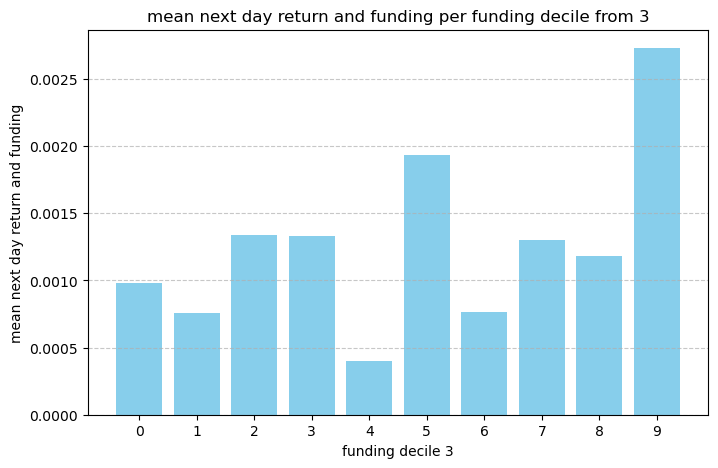

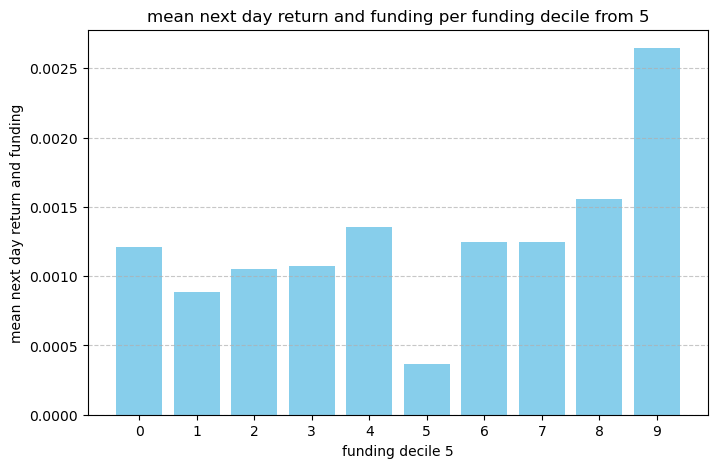

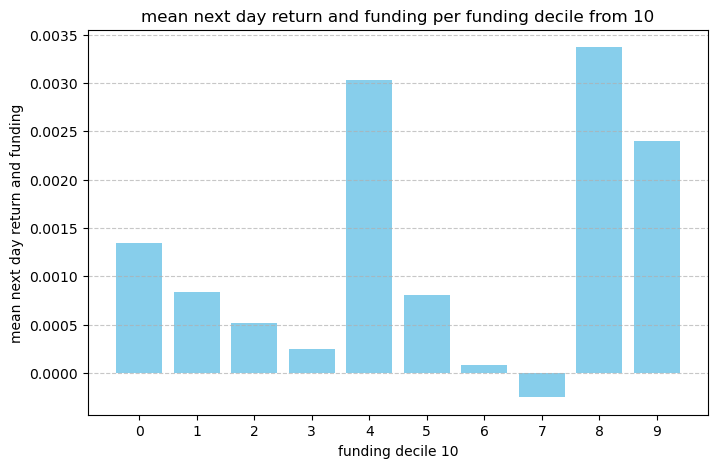

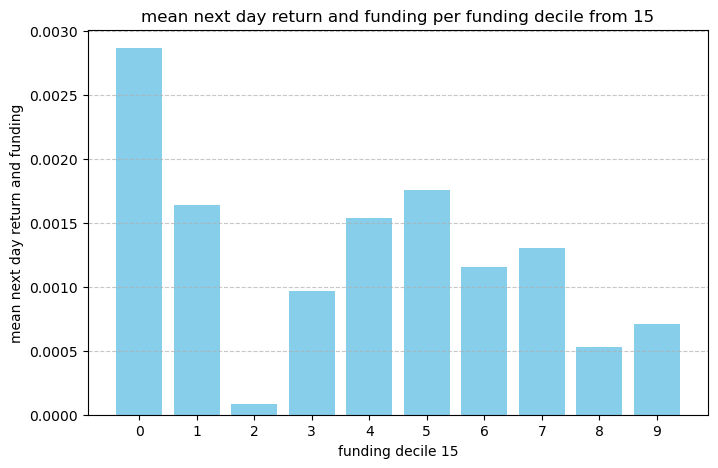

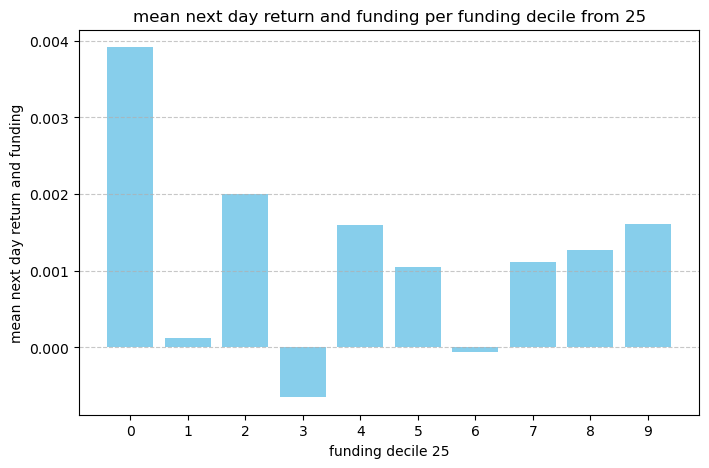

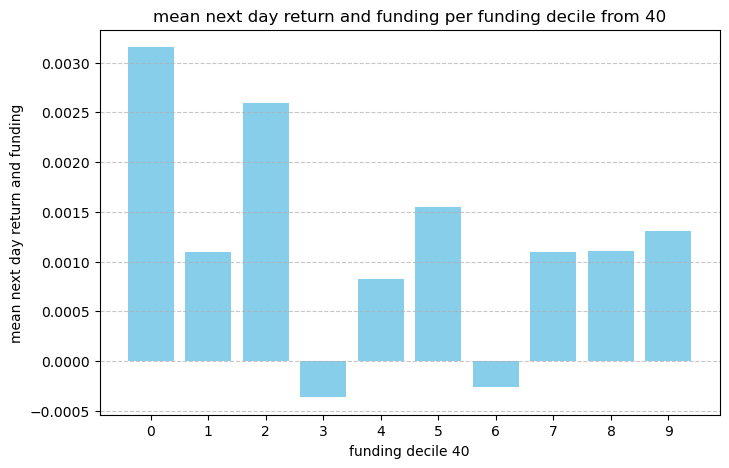

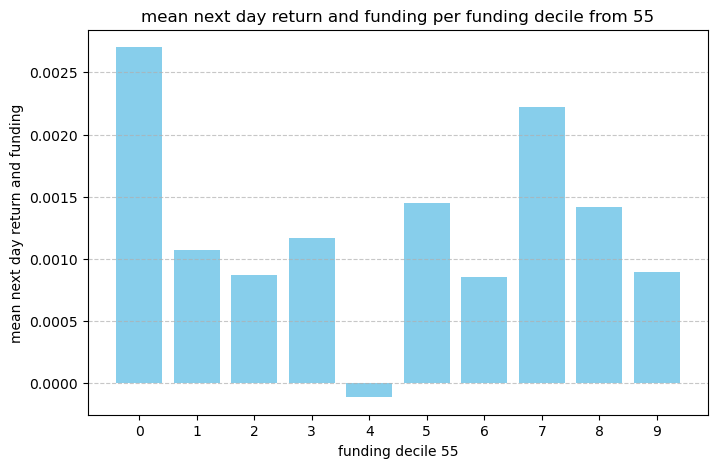

In [9]:
# decile plot to aim to see effects more clearly
for i in [3, 5, 10, 15, 25, 40, 55]:

    decile_means = df.groupby(f"funding_decile{i}")["next_returns_funding_volscaled"].mean()

    plt.figure(figsize=(8,5))
    plt.bar(decile_means.index, decile_means.values, color="skyblue")
    plt.xlabel(f"funding decile {i}")
    plt.ylabel("mean next day return and funding")
    plt.title(f"mean next day return and funding per funding decile from {i}")
    plt.xticks(decile_means.index)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()